# Optimization of sartorious transfer paramters of viscous liquids guided by Baysesian Optimization

## Summary

This notebook objective is to generate new suggestions of aspiration and dispense rates that will minimize the tansfer error while minimizing the time of transfer of a viscous liquid. 
The code is strucutred as follows:
1.  Fisrt section is for importing the relevant packages to perform BO, inclduing Pytorch and BOtorch
2.  Second section includes the definition of the BO_LiqTransfer class that includes the method optimized_suggestions() that generates BO optimized aspiration and dispense rate values for a particular data set.
3.  Third section includes the code to run in conjuction with the OT2 BO optimization of a viscous liquid. The steps for the optimziation are:

    i. Initilize a BO_LiTransfer objecet and load initilization data using data_from_csv() method

    ii. Run optimized_suggestions() method

    iii. Run liquid transfer using the best suggestion for aspiration and dispense rates in OT2 notebook

    iv. Update latest %error obtained from the transfer using suggested aspiration and dispense rates.
    
    v. Iterate through steps ii-iV
 

## 1. Imports

In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
from datetime import date

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

from gpytorch.constraints import GreaterThan
from torch.optim import SGD
from gpytorch.mlls import ExactMarginalLogLikelihood

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. BO_LiqTransfer class

In [2]:
class BO_LiqTransfer:

    def __init__(self, liquid_name):
        self.liquid_name = liquid_name
        self._data = None
        self.features = ['aspiration_rate','dispense_rate']
        self.objectives = ['%error','time_asp_1000']
        self.bmax = 1.25
        self.bmin = 0.1
        self._latest_suggestion = None
        self._latest_volume = None
        self._latest_acq_value = None
    

    def set_data(self,df):
        df['time_asp_1000'] = 1000/df['aspiration_rate'] + 1000/df['dispense_rate'] + df['delay_aspirate'] + df['delay_dispense']
        if 'acq_value' not in df.columns:
            df['acq_value'] = None
        self._data = df

    def data_from_csv(self,file_name):
        data = pd.read_csv(file_name)
        self.set_data(data)


    def update_data(self,df):
        updated_data = pd.concat([self._data,df],ignore_index=True)
        self.set_data(updated_data)
        return self._data
                                

    def xy_split(self, volume=1000):
        x_train = self._data[self.features].copy().where(self._data['volume']==volume).dropna(how='all') 
        y_train = self._data[self.objectives].copy().where(self._data['volume']==volume).dropna(how='all') 
        return x_train,y_train
        

    def set_bounds(self, x_train):
        return torch.vstack([x_train[0]*self.bmin, x_train[0]*self.bmax])



    def fit_surrogate(self, volume= 1000):
        x_train, y_train = self.xy_split(volume=volume)
        x_train = torch.tensor(x_train.to_numpy(dtype='float'), **tkwargs)
        y_train = torch.tensor(y_train.to_numpy(dtype='float'), **tkwargs)
        y_train[:,0] = -torch.absolute(y_train[:,0])
        y_train[:,1] = -torch.absolute(y_train[:,1])

        problem_bounds = self.set_bounds(x_train)
        time_upper = 1000/problem_bounds[0][0] +1000/problem_bounds[0][1] + 20
        error_upper = np.absolute(y_train[:,0].numpy()).min()*1.25
        ref_point = torch.tensor([-error_upper,-time_upper], **tkwargs)

        train_x_gp = normalize(x_train, problem_bounds)
        models = []
        for i in range(y_train.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, y_train[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model1 = ModelListGP(*models)
        mll1 = SumMarginalLogLikelihood(model1.likelihood, model1)

        fit_gpytorch_model(mll1)
    
        return model1, ref_point, train_x_gp, problem_bounds
    
    def optimized_suggestions(self, volume= 1000, random_state= 42):
        self._latest_volume = volume
        if random_state != None:
            torch.manual_seed(random_state) 
        standard_bounds = torch.zeros(2, len(self.features), **tkwargs)
        standard_bounds[1] = 1
        model1, ref_point, train_x_gp, problem_bounds = self.fit_surrogate(volume=volume)
        acq_func1 = qNoisyExpectedHypervolumeImprovement(
        model=model1,
        ref_point=ref_point, # for computing HV, must flip for BoTorch
        X_baseline=train_x_gp, # feed total list of train_x for this current iteration
        sampler=SobolQMCNormalSampler(sample_shape=512),  # determines how candidates are randomly proposed before selection
        objective=IdentityMCMultiOutputObjective(outcomes=np.arange(len(self.objectives)).tolist()), # optimize first n_obj col 
        prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        sobol1 = draw_sobol_samples(bounds=standard_bounds,n=512, q=1).squeeze(1)
        sobol2 = draw_sobol_samples(bounds=standard_bounds,n=512, q=1).squeeze(1)
        sobol_all = torch.vstack([sobol1, sobol2])
            
        acq_value_list = []
        for i in range(0, sobol_all.shape[0]):
            with torch.no_grad():
                acq_value = acq_func1(sobol_all[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())
                
        # filter the best 12 QMC candidates first
        sorted_x = sobol_all.cpu().numpy()[np.argsort((acq_value_list))]
        qnehvi_x = torch.tensor(sorted_x[-12:], **tkwargs)  
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(qnehvi_x, bounds=problem_bounds)
        new_x = pd.DataFrame(new_x.numpy(),columns=['aspiration_rate','dispense_rate'])
        new_x['acq_value'] = sorted(acq_value_list, reverse=True)[:12]
        self._latest_suggestion = new_x[['aspiration_rate','dispense_rate']].iloc[0]
        self._latest_acq_value = new_x['acq_value'].iloc[0] 
        return new_x
        





        
    
    


## 3. Initialization of automated plarform

In [3]:
#Import relevant python packages
import pandas as pd
import time
from matplotlib import pyplot as plt
from pathlib import Path
import sys
REPOS = 'GitHub'
ROOT = str(Path().absolute()).split(REPOS)[0]
sys.path.append(f'{ROOT}{REPOS}')

from polylectric.configs.SynthesisB1 import SETUP, LAYOUT_FILE

from controllably import load_deck      # optional
load_deck(SETUP.setup, LAYOUT_FILE)     # optional

platform = SETUP
platform.mover.verbose = False


Import: OK <controllably.misc.decorators>
Import: OK <controllably.misc.helper>
Import: OK <controllably.misc.factory>
Import: OK <controllably.misc.layout>
Import: OK <controllably.misc.logger>
Import: OK <controllably.misc.misc_utils>


Import: OK <controllably.Compound.compound_utils>
Import: OK <controllably.Compound.LiquidMover.liquidmover_utils>


Import: OK <controllably.Move.move_utils>
Import: OK <controllably.Move.Jointed.jointed_utils>
Import: OK <controllably.Move.Jointed.Dobot.dobot_utils>
Import: OK <controllably.Move.Jointed.Dobot.m1pro_utils>
Import: OK <controllably.Move.Jointed.Dobot.mg400_utils>
ClearError()
receive: ClearError()
EnableRobot()
receive: EnableRobot()
User(0)
receive: User(0)
Tool(0)
receive: Tool(0)
SetArmOrientation(1,1,1,1)
receive: SetArmOrientation(1,1,1,1)
Infeasible coordinates! (0.0, 0.0, 200.0)
Infeasible coordinates! (300.0, 1.1368683772161603e-13, 0.0)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 3.000s (1.000x

In [4]:
#Initialization of variables for platfomr objects
pipette= platform.setup
deck = platform.setup.deck
balance = platform.balance
balance_deck = deck.slots['1']
source = deck.slots['2']
tip_rack = deck.slots['3']
bin = deck.slots['4']
pipette.mover.setSpeed(50)
print(balance_deck)
print(source)
print(tip_rack)
print(bin)


SpeedFactor(50)
receive: SpeedFactor(50)
Mass_balance_plastic_jar 1 Well Plate 15000 uL at Slot 1
Polyelectric 6 Well Plate 15000 ÂµL at Slot 2
Eppendorf Motion 96 Tip Rack 1000 ÂµL at Slot 3
Polyetric_bin at Slot 4


In [5]:
#Check if balance is connected
balance.zero()
balance.toggleRecord(True)
time.sleep(5)
print(balance.buffer_df.iloc[-1])
balance.toggleRecord(False)

Listening...
Zeroing... (5s)
Stop listening...
Zeroing complete.
Listening...
Time        2023-05-24 14:22:19.018213
Value                           161450
Factor                        6.862879
Baseline                 249632.054945
Mass                     -12849.133627
Name: 24, dtype: object
Stop listening...


In [6]:
#Stablish initial height of liquid on the source vial
pipette_name = 'rLine1000'
liquid_level = 10

## 3. Guided BO optimization
i.   Create BO_LiqTransfer object and load data set.

Please set liquid name and volume to transfer according to the experiment.

In [7]:
# Change according to experiment
std = '204'
liquid_name = 'Viscosity_std_' + std 
density = 0.8639
# Do not change
liq = BO_LiqTransfer(liquid_name)
folder = (r"C:\Users\admin\Documents\GitHub\viscosity_liquid_transfer_Pablo\Sartorious_experiments\Initialisation_Data")
liq.data_from_csv(folder+r'/'+'Initialisation_'+std+'.csv')
liq._data

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error,Transfer_Observation,Comment,iteration,time_asp_1000,acq_value
0,Viscosity_std_204,rLine1000,1000.0,127.130775,127.130775,False,10,10,0,0.8639,78.725538,0.758603,-12.188579,Complete Transfer,Blowout before,1,35.731832,None
1,Viscosity_std_204,rLine1000,500.0,127.130775,127.130775,False,10,10,0,0.8639,71.047900,0.402936,-6.717021,Complete Transfer,Blowout before,1,35.731832,None
2,Viscosity_std_204,rLine1000,300.0,127.130775,127.130775,False,10,10,0,0.8639,67.998543,0.238253,-8.070855,Complete Transfer,Blowout before,1,35.731832,None
3,Viscosity_std_204,rLine1000,1000.0,158.913469,158.913469,False,10,10,0,0.8639,75.887200,0.682425,-21.006491,Complete Transfer,Blowout before,2,32.585466,None
4,Viscosity_std_204,rLine1000,500.0,158.913469,158.913469,False,10,10,0,0.8639,69.869834,0.394674,-8.629705,Complete Transfer,Blowout before,2,32.585466,None
5,Viscosity_std_204,rLine1000,300.0,158.913469,158.913469,False,10,10,0,0.8639,67.242198,0.222603,-14.109134,Complete Transfer,Blowout before,2,32.585466,None
6,Viscosity_std_204,rLine1000,1000.0,12.713078,158.913469,False,10,10,0,0.8639,148.588744,0.683343,-20.900230,Complete Transfer,Blowout before,3,104.951893,None
7,Viscosity_std_204,rLine1000,500.0,12.713078,158.913469,False,10,10,0,0.8639,105.732822,0.375513,-13.065648,Complete Transfer,Blowout before,3,104.951893,None
8,Viscosity_std_204,rLine1000,300.0,12.713078,158.913469,False,10,10,0,0.8639,88.841983,0.208819,-19.427767,Complete Transfer,Blowout before,3,104.951893,None
9,Viscosity_std_204,rLine1000,1000.0,158.913469,12.713078,False,10,10,0,0.8639,148.284910,0.844441,-2.252405,Complete Transfer,Blowout before,4,104.951893,None



ii.   Run BO_LiqTransfer.optimized_suggestions() method to obtain optimized aspiration and dispense rates.



In [211]:
volume = 300
liq.optimized_suggestions(volume)


,aspiration_rate,dispense_rate,acq_value
0,144.440115,85.948340,26.357397
1,140.503247,93.003366,26.143952
2,146.962835,96.555854,23.527563
3,152.941562,98.803662,23.225867
4,147.223706,94.351589,22.621799
5,150.839369,85.775166,21.994747
6,148.068811,91.245188,21.081766
7,150.059309,89.721941,21.053994
8,151.835513,93.778506,20.602917
9,154.323686,95.712126,19.745417


In [212]:
liquids_dict = {
  liquid_name :{
        "rLine1000": {
            "aspiration_rate": liq._latest_suggestion['aspiration_rate'], 
            "dispense_rate": liq._latest_suggestion['dispense_rate'], 
            "blow_out" : False, 
            "delay_aspirate" : 10, 
            "delay_dispense" : 10, 
            "delay_blow_out" : 0, 
            },
    }

}

iii. Run liquid transfer using the best suggestion for aspiration and dispense rates in OT2 notebook.


In [213]:
#Check if new tip is required
pipette.mover.setSpeed(50)
pipette.mover.setHandedness(False)

if pipette.liquid.isTipOn()== False:
    pipette.attachTip()

#Transfer start
start = time.time()

#Aspirate step
pipette.mover.safeMoveTo(source.wells['A1'].from_bottom((0,0,liquid_level-5)))
pipette.liquid.aspirate(volume, speed=liquids_dict[liquid_name][pipette_name]['aspiration_rate'])
time.sleep(liquids_dict[liquid_name][pipette_name]['delay_aspirate'])

pipette.touchTip(source.wells['A1'])

#Dispense step
pipette.mover.safeMoveTo(balance_deck.wells['A1'].from_top((0,0,-5)))

balance.tare()
balance.clearCache()
balance.toggleRecord(True)
time.sleep(5)


pipette.liquid.dispense(volume, speed=liquids_dict[liquid_name][pipette_name]['dispense_rate'])

time.sleep(liquids_dict[liquid_name][pipette_name]['delay_dispense'])

#Blowout step
if liquids_dict[liquid_name][pipette_name]['blow_out'] == True:
    pipette.liquid.blowout(home=False)
    time.sleep(liquids_dict[liquid_name][pipette_name]['delay_blow_out'])

#Transfer termination
finish = time.time()
time_m = finish - start

pipette.mover.safeMoveTo(source.wells['A1'].top)
time.sleep(5)
balance.toggleRecord(False)
if liquids_dict[liquid_name][pipette_name]['blow_out'] == True:
    pipette.liquid.home()

#Do blowout
pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()
time.sleep(10)
pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()
time.sleep(10)
pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()


Tip capacitance: 248
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 1.265s (1.000x)
[206.843 -146.682 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[206.843 -146.682 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,53.959370,10.000000,0.000000,0.000000)
Move time: 1.460s (1.000x)
[206.843 -146.682 53.959], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 300.0 uL...
Target: 300.0 uL at 144.4401147085867 uL/s...
Best parameters: SpeedParameters(preset=410, intervals=1, step_size=120, delay=1.3452780176813826)
SpeedParameters(preset=410, intervals=1, step_size=120, delay=1.3452780176813826)
Speed 3: 410 uL/s
Aspiration time: 2.0772896999842487s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(206.843094,-146.682146,63.510000,10.000000,0.000000,0.000000

'ok'

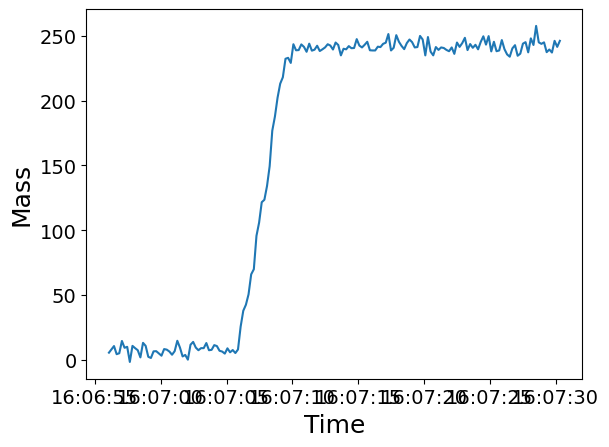

In [214]:
fig,axs = plt.subplots()

axs.plot(balance.buffer_df['Time'],balance.buffer_df['Mass'])

axs.set_xlabel('Time')
axs.set_ylabel('Mass')

plt.show()

In [215]:
#Record trasnfer values 

m = (balance.buffer_df.iloc[-10:,-1].mean()-balance.buffer_df.iloc[:10,-1].mean())/1000
error = (m-density*volume/1000)/(density/1000*volume)*100

#New dataframe
df = pd.DataFrame(columns = ['liquid', 'pipette', 'volume', 'aspiration_rate', 'dispense_rate','blow_out', 'delay_aspirate', 'delay_dispense', 'delay_blow_out', 'density', 'time', 'm', '%error', 'acq_value', 'Transfer_Observation', 'Comment'])
df = df.astype({'liquid':str,'pipette':str,'blow_out':bool,'Transfer_Observation':str,'Comment':str})
df = pd.concat([df,pd.DataFrame(liquids_dict[liquid_name][pipette_name],index=[0])],ignore_index=True)
df.iloc[-1,-6] = time_m
df.iloc[-1,2] = volume
df.iloc[-1, 0] = liquid_name
df.iloc[-1, 1] = pipette_name
df.iloc[-1,-7] = density
df.iloc[-1, -5] = m
df.iloc[-1,-4]= error
df.iloc[-1, -3] = liq._latest_acq_value

In [216]:
#Update liquid level
#liquid_level = liquid_level - 1*volume/1000
liquid_level = liquid_level - 1.2*m/density

In [217]:
liquid_level 

9.121076189987322

In [218]:
#Observe error made
df.tail(20)

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error,acq_value,Transfer_Observation,Comment
0,Viscosity_std_204,rLine1000,300,144.440115,85.94834,False,10,10,0,0.8639,68.87539,0.236344,-8.807368,26.357397,NaN,NaN


In [219]:
#Assign category of observation of transfer such as Incomplete Dispense, Incomplete Aspiration, 
#Incomplete Aspiration and Dispense, Complete Transfer. 
#Comment if any unexpected exprimental mistakes or changes were performed that have to be taken into account.
df.iloc[-1,-2]= 'Incomplete Dispense'
df.iloc[-1,-1]= 'Blowout before'

iv. Update latest %error obtained from the transfer using suggested aspiration and dispense rates.

In [220]:
liq.update_data(df) 


,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error,Transfer_Observation,Comment,iteration,time_asp_1000,acq_value
0,Viscosity_std_204,rLine1000,1000.0,127.130775,127.130775,False,10,10,0,0.8639,78.725538,0.758603,-12.188579,Complete Transfer,Blowout before,1.0,35.731832,None
1,Viscosity_std_204,rLine1000,500.0,127.130775,127.130775,False,10,10,0,0.8639,71.0479,0.402936,-6.717021,Complete Transfer,Blowout before,1.0,35.731832,None
2,Viscosity_std_204,rLine1000,300.0,127.130775,127.130775,False,10,10,0,0.8639,67.998543,0.238253,-8.070855,Complete Transfer,Blowout before,1.0,35.731832,None
3,Viscosity_std_204,rLine1000,1000.0,158.913469,158.913469,False,10,10,0,0.8639,75.8872,0.682425,-21.006491,Complete Transfer,Blowout before,2.0,32.585466,None
4,Viscosity_std_204,rLine1000,500.0,158.913469,158.913469,False,10,10,0,0.8639,69.869834,0.394674,-8.629705,Complete Transfer,Blowout before,2.0,32.585466,None
5,Viscosity_std_204,rLine1000,300.0,158.913469,158.913469,False,10,10,0,0.8639,67.242198,0.222603,-14.109134,Complete Transfer,Blowout before,2.0,32.585466,None
6,Viscosity_std_204,rLine1000,1000.0,12.713078,158.913469,False,10,10,0,0.8639,148.588744,0.683343,-20.90023,Complete Transfer,Blowout before,3.0,104.951893,None
7,Viscosity_std_204,rLine1000,500.0,12.713078,158.913469,False,10,10,0,0.8639,105.732822,0.375513,-13.065648,Complete Transfer,Blowout before,3.0,104.951893,None
8,Viscosity_std_204,rLine1000,300.0,12.713078,158.913469,False,10,10,0,0.8639,88.841983,0.208819,-19.427767,Complete Transfer,Blowout before,3.0,104.951893,None
9,Viscosity_std_204,rLine1000,1000.0,158.913469,12.713078,False,10,10,0,0.8639,148.28491,0.844441,-2.252405,Complete Transfer,Blowout before,4.0,104.951893,None


v. Iterate trhough last two code cells.

In [221]:
#save after each standard-experiment iteration
liq._data.to_csv(liquid_name+'_BOTorch_exp2.csv', index = False)

In [ ]:
liq.xy_split(500)[1].to_numpy(dtype='float')

In [133]:
liq._data

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error,Transfer_Observation,Comment,iteration,time_asp_1000,acq_value
0,Viscosity_std_204,rLine1000,1000.0,127.130775,127.130775,False,10,10,0,0.8639,78.725538,0.758603,-12.188579,Complete Transfer,Blowout before,1.0,35.731832,None
1,Viscosity_std_204,rLine1000,500.0,127.130775,127.130775,False,10,10,0,0.8639,71.0479,0.402936,-6.717021,Complete Transfer,Blowout before,1.0,35.731832,None
2,Viscosity_std_204,rLine1000,300.0,127.130775,127.130775,False,10,10,0,0.8639,67.998543,0.238253,-8.070855,Complete Transfer,Blowout before,1.0,35.731832,None
3,Viscosity_std_204,rLine1000,1000.0,158.913469,158.913469,False,10,10,0,0.8639,75.8872,0.682425,-21.006491,Complete Transfer,Blowout before,2.0,32.585466,None
4,Viscosity_std_204,rLine1000,500.0,158.913469,158.913469,False,10,10,0,0.8639,69.869834,0.394674,-8.629705,Complete Transfer,Blowout before,2.0,32.585466,None
5,Viscosity_std_204,rLine1000,300.0,158.913469,158.913469,False,10,10,0,0.8639,67.242198,0.222603,-14.109134,Complete Transfer,Blowout before,2.0,32.585466,None
6,Viscosity_std_204,rLine1000,1000.0,12.713078,158.913469,False,10,10,0,0.8639,148.588744,0.683343,-20.90023,Complete Transfer,Blowout before,3.0,104.951893,None
7,Viscosity_std_204,rLine1000,500.0,12.713078,158.913469,False,10,10,0,0.8639,105.732822,0.375513,-13.065648,Complete Transfer,Blowout before,3.0,104.951893,None
8,Viscosity_std_204,rLine1000,300.0,12.713078,158.913469,False,10,10,0,0.8639,88.841983,0.208819,-19.427767,Complete Transfer,Blowout before,3.0,104.951893,None
9,Viscosity_std_204,rLine1000,1000.0,158.913469,12.713078,False,10,10,0,0.8639,148.28491,0.844441,-2.252405,Complete Transfer,Blowout before,4.0,104.951893,None


In [199]:
pipette.mover.home()

SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 1.265s (1.000x)
[206.843 -146.682 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 2.934s (0.500x)
[300.000 0.000 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (1.000x)
[300.000 0.000 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Homed


True

In [200]:
liquid_level = 10